In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import numpy.linalg

import yfinance as yf
import pandas as pd

In [55]:
#####
# 12-month data from 11/12/2023 to 11/12/2024
##
FY2022_START='2022-11-24'
FY2019_START='2019-11-24'
FY2024_END='2024-11-24'
NUM_BINS= 3

googleTicker='GOOG'

googleDf = yf.download(googleTicker, start=FY2022_START,end= FY2024_END)
# googleDf.to_csv("google_stock_data.csv", index=False)

# googleDf = pd.read_csv("google_stock_data.csv")
googleDf_close = googleDf['Close'].GOOG


# googleDf_close = googleDf.loc[1:600, ["Close"]]
googleDf_close

[*********************100%***********************]  1 of 1 completed


Date
2022-11-25     97.599998
2022-11-28     96.250000
2022-11-29     95.440002
2022-11-30    101.449997
2022-12-01    101.279999
                 ...    
2024-11-18    176.800003
2024-11-19    179.580002
2024-11-20    177.330002
2024-11-21    169.240005
2024-11-22    166.570007
Name: GOOG, Length: 502, dtype: float64

In [56]:
googleDf_close.describe()

count    502.000000
mean     137.958317
std       27.896121
min       86.459999
25%      120.182499
50%      137.909996
75%      163.225002
max      192.660004
Name: GOOG, dtype: float64

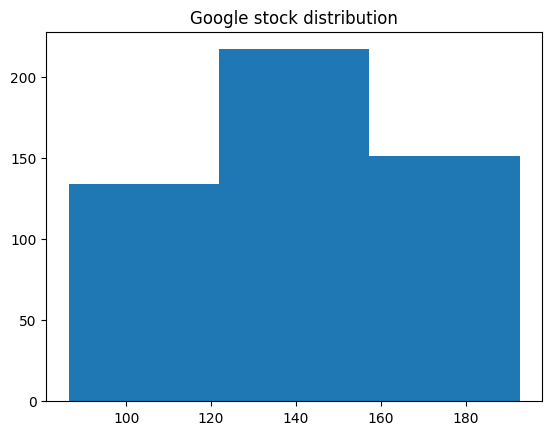

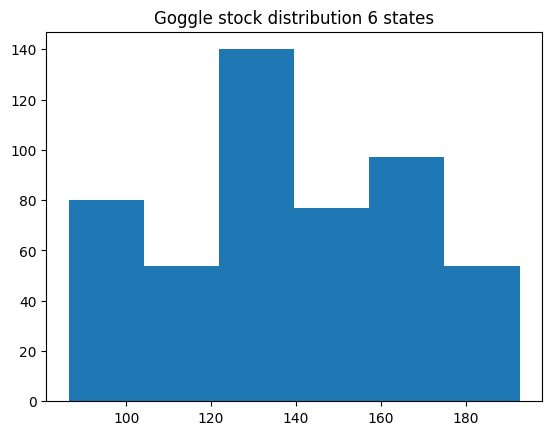

In [57]:
#####
# binCounts= number of examples in each bin
# binEdges-  left edge of each bin
# patches- rectangles used to plot histogram's bars
##

plt.figure(1)
plt.title('Google stock distribution')
binCountsGOOG, binEdgesGOOG, patchesGOOG= plt.hist(googleDf_close, NUM_BINS)

plt.figure(2)
plt.title("Goggle stock distribution 6 states")
binCountsGOOGSix, binEdgesGOOGSix, patchesGOOGSix= plt.hist(googleDf_close, 6)

In [58]:
#####
# Determine the state of a closing stock price
##


def checkState(closingPrice, binEdges):
    leftEdge= 0
    rightEdge= 0
    stateValue= -1
    
    for e in range(0,len(binEdges)-1):
        leftEdge= binEdges[e]
        rightEdge= binEdges[e + 1]
        
        if (e != len(binEdges)-2):
            if (closingPrice >= leftEdge) & (closingPrice < rightEdge):
                stateValue= e
                break
        else:
            if (closingPrice >= leftEdge) & (closingPrice <= rightEdge):
                stateValue= e
                break
                
    return stateValue

#####
# Quick tester for checkState
##
checkState(170, binEdgesGOOG)

2

In [59]:
#####
# Builds the Markov Matrix in place, named the transition matrix, A transition
# has it's entries respresented as probabilities the addition of the row values is equal to one
# 
# Data Structures:
# trMatrix: a n * n Matrix, represented by a numpy 2d array
# dfData: a pandas series, of closing prices
# binEdges: a array of 4 closing prices used to represent the bins



def buildMarkovMatrix(trMatrix, dfData, binEdges):
    # local variables
    sCurr= 0
    sNext= 0
    firstTime= True
    DEBUG=True

    for price in dfData:
        # print(f'buildMarkovMatrix:  price={price}')

        # this code block allows for pairwise iteration where we are able to evalute both states
        if(firstTime):
            sNext= checkState(price, binEdges)
            sCurr= sNext
            firstTime= False
            # if (DEBUG):
            #     print(f'buildMarkovMatrix:  temp={price}:  (curr, next)= (S{sCurr},S{sNext})')
            continue;
        
        # Now that we have access to both states we can just 
        sCurr= sNext
        sNext= checkState(price, binEdges)
    
        # if (DEBUG):
        #     print(f'buildMarkovMatrix:  price= {price}:  (curr, next)= (S{sCurr},S{sNext})')

        trMatrix[sCurr, sNext]= trMatrix[sCurr,sNext] + 1



In [60]:
######
#  set the number of states 
###
numStates= len(binEdgesGOOG)-1
print(numStates)

#####
# Initialize Markov Matrix to zeros
###
trMatrixGOOG= np.zeros((numStates,numStates),dtype=np.float64)
print(trMatrixGOOG)


#####
# create a transition matrix with more states to test the steady state distribution
numStates_2 = len(binEdgesGOOGSix) -1
trMatrixGOOG_sixStates = np.zeros((numStates_2, numStates_2), dtype=np.float64)


3
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [61]:
buildMarkovMatrix(trMatrixGOOG, googleDf_close, binEdgesGOOG)
buildMarkovMatrix(trMatrixGOOG_sixStates, googleDf_close, binEdgesGOOGSix)



In [62]:
#####
# Measure row count and column count then
# normalize row counts to make distributions
#
# result is Markov Matrix, p 
##

def normalizeMarkovMatrix(trMatrix):
    rows,cols= trMatrix.shape


    for i in range(0,rows):
        rowSum= sum(trMatrix[i])
    
        ###
        # Debug artifact
        # print(rowSum)
    
    
        if(rowSum != 0):
            trMatrix[i]= trMatrix[i]/rowSum

    return trMatrix

normalizeMarkovMatrix(trMatrixGOOG)
trMatrixGOOG_sixStates = normalizeMarkovMatrix(trMatrixGOOG_sixStates)



Converged at step 229


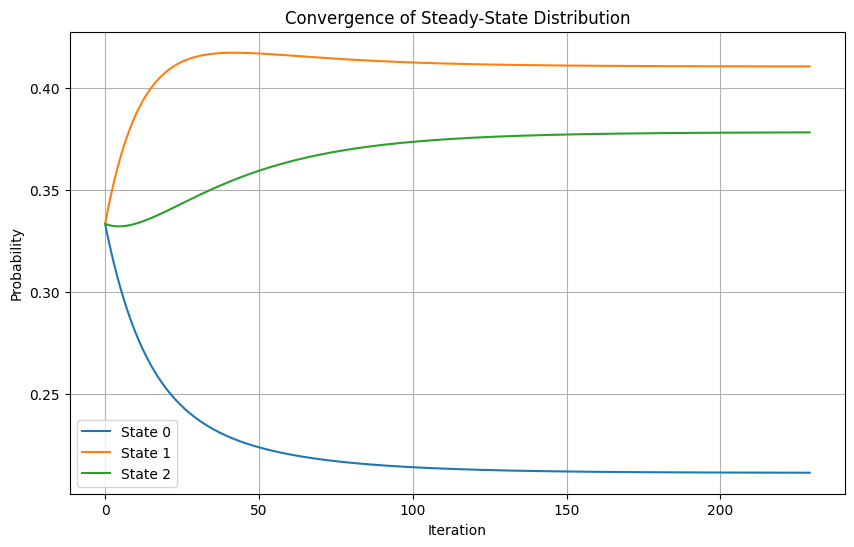

steady state distribution

[0.21129532 0.41051966 0.37818502]

Converged at step 342


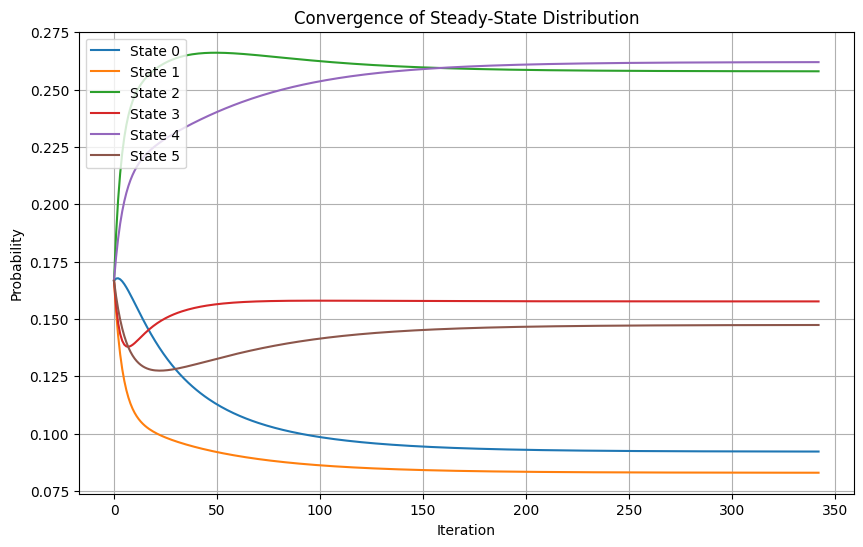

steady state distribution

[0.09216295 0.08293065 0.25796817 0.15762937 0.26196393 0.14734493]



array([0.09216295, 0.08293065, 0.25796817, 0.15762937, 0.26196393,
       0.14734493])

In [63]:
#####
# This function takes in transition_matrix, creates a unifrom distributions, then gives n number 
# of max steps to allow the distribution to converge



def steady_state_distribution(transition_matrix, max_steps=1000, tolerance=1e-12):
    DEBUG = False

    # obtain the shape of the transition_matrix, 
    num_states = transition_matrix.shape[0]

    # Create a unifrom distribution that we can start off with
    pi_0 = np.ones(num_states) / num_states

    # assign pi_prev for starting the process
    pi_prev = pi_0


    # These are the steady state distribtuions that can be used to visualize convergence
    steadyStateDistribution = np.zeros((max_steps + 1, num_states))
    steadyStateDistribution[0] = pi_0  # Store the initial distribution

    if (DEBUG):
        print(f"Visualized: steadyStateDistribution")
        print(steadyStateDistribution)

    # track the converged step
    converged_step = max_steps


    for step in range(1, max_steps + 1):
        # Compute the next step
        # Documentation (Since this is new to me): https://numpy.org/doc/stable/reference/generated/numpy.matmul.html
        pi_next = np.matmul(pi_prev, transition_matrix)
        
        # append the steady state distribtuions
        steadyStateDistribution[step] = pi_next

        # Check for convergence, 
        if np.allclose(pi_next, pi_prev, atol=tolerance):
            print(f"Converged at step {step}")
            converged_step = step
            break
        
        pi_prev = pi_next

    # array to include only up to the converged step for plotting
    steadyStateDistribution = steadyStateDistribution[:converged_step + 1]


    # Plot the convergence
    plt.figure(figsize=(10, 6))

    # interate and plot states respectivly
    for state in range(num_states):
        plt.plot(
            steadyStateDistribution[:, state],
            label=f"State {state}"
        )
    plt.title("Convergence of Steady-State Distribution")
    plt.xlabel("Iteration")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid()
    plt.show()

    print("steady state distribution")
    print()
    print(steadyStateDistribution[-1])
    print()
    
    return pi_next

steady_state_distribution(trMatrixGOOG)
steady_state_distribution(trMatrixGOOG_sixStates)

In [64]:
########
#
# Write a function that performs perediction using a markov chain.
# For example, markovChainPrediction(...)
#
#
# Algorithm for prediction using markov chain.
#
# 1.  select a time horizon for prediction, i.e. time steps h= 1,2,3,...10
#
# 2.  compute the h-step transition matrix M^{h}
#
# 3.  obtain data structure containing Closing price measurements,  m_1, m_2,..., m_n
#
# 4.  begin at position in price measurements,  m_i
#
# 5.  convert to state  S_i = checkState(m_i)
#
# 6.  set this as your landing distribution at time t0, namely P_0
#
# 7.  compute the landing distribution after h-many time-steps, P_0 x M^{h}
#
# 8.  step #7 results in landing distribution P_h, find the state S_i with the max probability S_max
#
# 9.  Given your starting state S_i at m_i,  find the measurement h-steps away m_(i+h)
#     and convert it to a state  S_(i+h) = checkState( m_(i+h) )
#
# 10. test if the prediction  S_max == S_(i+h) 
#     If yes, then increment successes= sucesses+1
#     if no, then increment failures= failures+1
#
# 11. Compute rate= successes/(successes + failure),  this is your generalization
#
####

def markovChainPrediction(time_horizon, closingPrice, bin_edges, transition_matrix):
    # keep a rolling count for accuracy calcualtion in this function
    successes = 0
    failures = 0
    
    # iterate until last time_horizon entry 
    for i in range(len(closingPrice) - time_horizon):
        
        # obtain the current closing price
        currentPrice = closingPrice[i]

        # run the check state function
        current_state = checkState(currentPrice, bin_edges)
        
        # Initial state distribution (one-hot)
        P0 = np.zeros(len(bin_edges) - 1)
        P0[current_state] = 1
        
        # Compute h-step transition matrix over the time horizon
        # Documentation : np/linalg.matrix_power, this exponentiates the matrix by the h-step
        h_step_matrix = np.linalg.matrix_power(transition_matrix, time_horizon)

        
        # Compute landing distribution by mulitplying the vectors
        P_h = np.matmul(P0, h_step_matrix)

        # Use np.argmax to disgretize the the 
        predicted_state = np.argmax(P_h)
        
        # Actual state after h steps
        actual_price = closingPrice[i + time_horizon]
        actual_state = checkState(actual_price, bin_edges)
        
        # Compare predictions
        if predicted_state == actual_state:
            successes += 1
        else:
            failures += 1
    
    # Generalization performance
    return successes / (successes + failures)


markovChainPrediction(3, googleDf_close, binEdgesGOOG, trMatrixGOOG)


    

/var/folders/1h/mvsdnz3d6cl7mpc2kmr2bchr0000gn/T/ipykernel_10379/3045898033.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  currentPrice = closingPrice[i]
/var/folders/1h/mvsdnz3d6cl7mpc2kmr2bchr0000gn/T/ipykernel_10379/3045898033.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actual_price = closingPrice[i + time_horizon]


0.935871743486974

In [65]:
def runExperiment(closing_prices, num_bins_range, time_horizon_range):
    results = []
    
    for num_bins in num_bins_range:
        # Discretize data
        bin_edges = np.histogram(closing_prices, bins=num_bins)[1]
        
        # Build and normalize transition matrix
        transition_matrix = np.zeros((num_bins, num_bins))
        buildMarkovMatrix(transition_matrix, closing_prices, bin_edges)
        normalizeMarkovMatrix(transition_matrix)
        
        for h in time_horizon_range:
            # Calculate generalization performance
            performance = markovChainPrediction(h, closing_prices, bin_edges, transition_matrix)
            results.append({'num_bins': num_bins, 'horizon': h, 'performance': performance})
    
    return pd.DataFrame(results)

possiblities = list(range(2, 11))
preformanceDf = runExperiment(googleDf_close, possiblities, possiblities)
preformanceDf

/var/folders/1h/mvsdnz3d6cl7mpc2kmr2bchr0000gn/T/ipykernel_10379/3045898033.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  currentPrice = closingPrice[i]
/var/folders/1h/mvsdnz3d6cl7mpc2kmr2bchr0000gn/T/ipykernel_10379/3045898033.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actual_price = closingPrice[i + time_horizon]


,num_bins,horizon,performance
0,2,2,0.960000
1,2,3,0.953908
2,2,4,0.943775
3,2,5,0.937626
4,2,6,0.931452
...,...,...,...
76,10,6,0.596774
77,10,7,0.575758
78,10,8,0.508097
79,10,9,0.490872


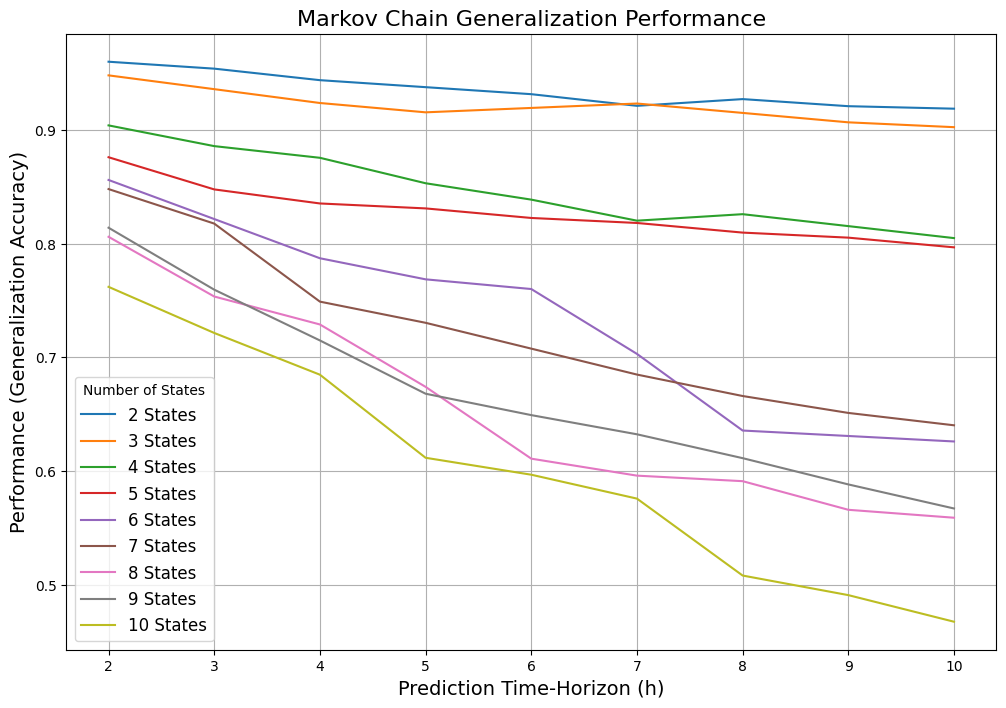

average accuracy: 0.76744


In [66]:
def plot_results(results_df, title):
    plt.figure(figsize=(12, 8))

    # Iterate over unique numbers of bins and plot their corresponding performance
    for num_bins in sorted(results_df['num_bins'].unique()):
        subset = results_df[results_df['num_bins'] == num_bins]
        plt.plot(subset['horizon'], subset['performance'], label=f"{num_bins} States")

    # Add titles and labels
    plt.title(title, fontsize=16)
    plt.xlabel("Prediction Time-Horizon (h)", fontsize=14)
    plt.ylabel("Performance (Generalization Accuracy)", fontsize=14)
    plt.legend(title="Number of States", fontsize=12)
    plt.grid()
    plt.show()

plot_results(preformanceDf, "Markov Chain Generalization Performance")
print(f"average accuracy: {preformanceDf['performance'].mean().round(5)}")


In [67]:
googleDfFive = yf.download(googleTicker, start=FY2019_START,end= FY2024_END)
googleDfFive_close = googleDfFive['Close'].GOOG

[*********************100%***********************]  1 of 1 completed


/var/folders/1h/mvsdnz3d6cl7mpc2kmr2bchr0000gn/T/ipykernel_10379/3045898033.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  currentPrice = closingPrice[i]
/var/folders/1h/mvsdnz3d6cl7mpc2kmr2bchr0000gn/T/ipykernel_10379/3045898033.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actual_price = closingPrice[i + time_horizon]


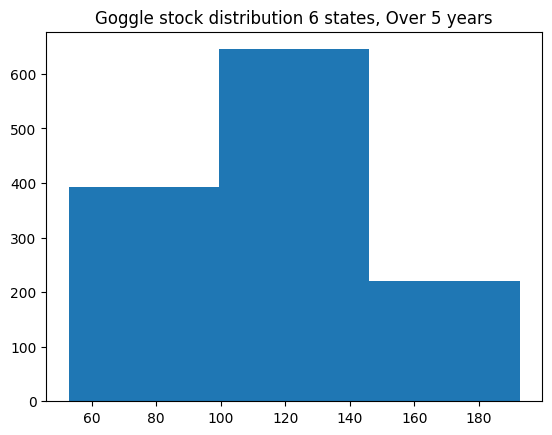

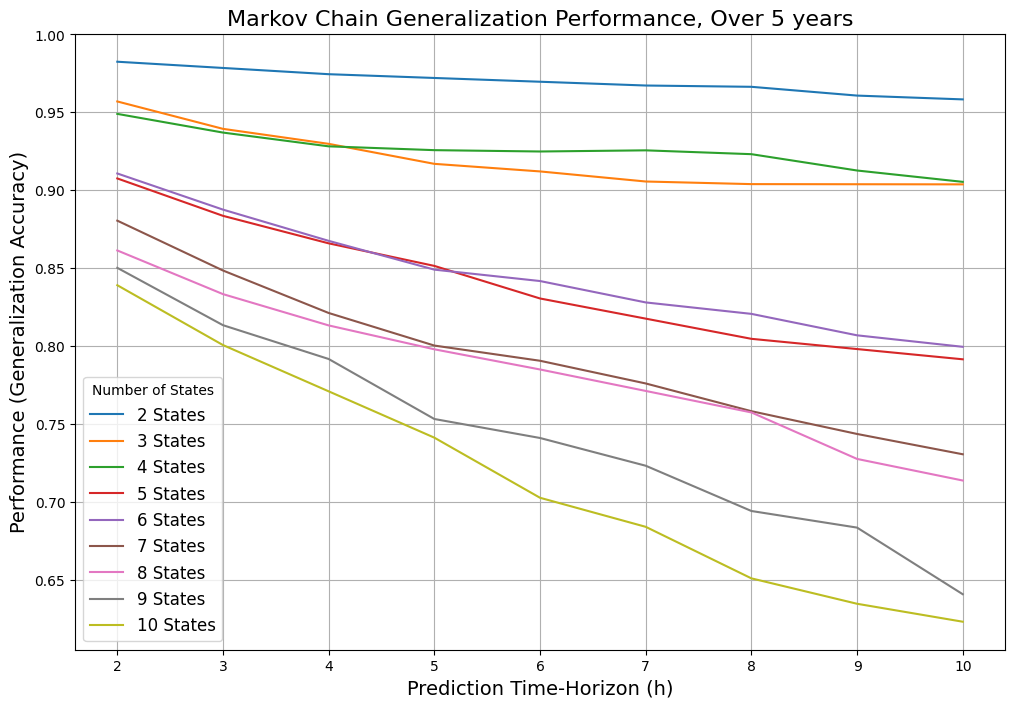

average accuracy: 0.83771


In [68]:
# Here we plot a histogram of the 5 year data, then run all the prevoius functions to obtain the preformance 
plt.figure(1)
plt.title("Goggle stock distribution 3 states, Over 5 years")
binCountsGOOG, binEdgesGOOG, patchesGOOG = plt.hist(googleDfFive_close, 3)
possiblities = list(range(2, 11))
preformanceDfFive = runExperiment(googleDfFive_close, possiblities, possiblities)
plot_results(preformanceDfFive, "Markov Chain Generalization Performance, Over 5 years")
print(f"average accuracy: {preformanceDfFive['performance'].mean().round(5)}")


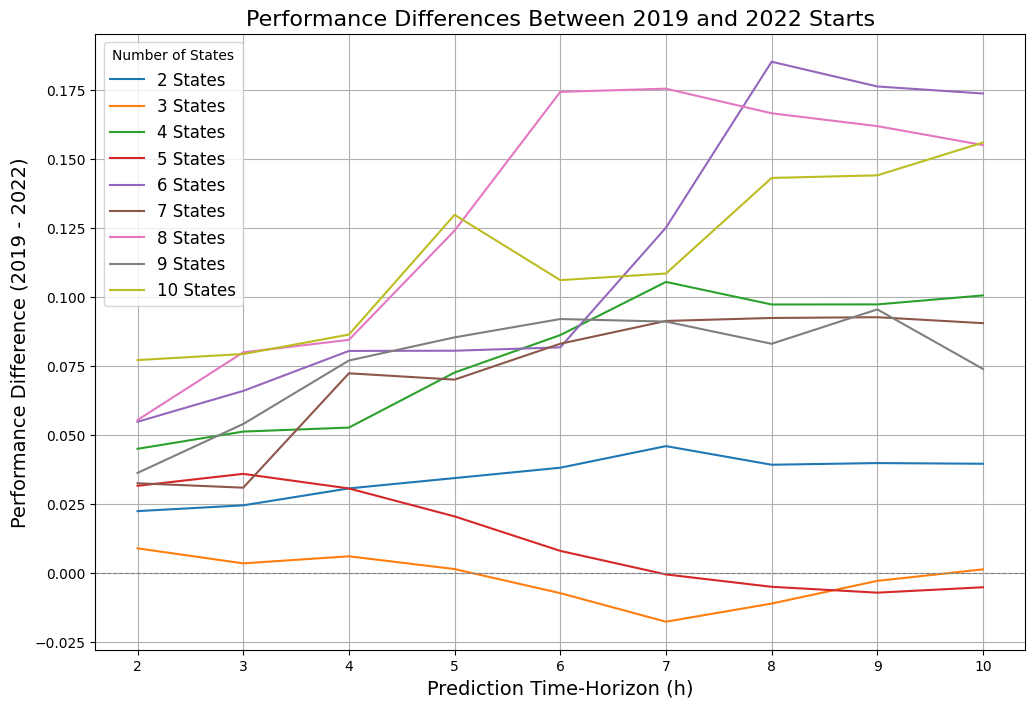

,num_bins,horizon,performance_2019,performance_2022,performance_diff
0,2,2,0.982484,0.960000,0.022484
1,2,3,0.978486,0.953908,0.024578
2,2,4,0.974482,0.943775,0.030707
3,2,5,0.972067,0.937626,0.034441
4,2,6,0.969649,0.931452,0.038197
...,...,...,...,...,...
76,10,6,0.702875,0.596774,0.106101
77,10,7,0.684253,0.575758,0.108495
78,10,8,0.651200,0.508097,0.143103
79,10,9,0.634908,0.490872,0.144036


In [69]:
def compare_performance_between_periods(preformanceDfFive, preformanceDf):
    # Merge the two preformance dataframe
    comparison_df = pd.merge(
        preformanceDfFive, preformanceDf, 
        on=['num_bins', 'horizon'], 
        suffixes=('_2019', '_2022')
    )
    
    # Calculate performance difference
    comparison_df['performance_diff'] = comparison_df['performance_2019'] - comparison_df['performance_2022']

    # Pivot for easier viulaization in matplot lib
    pivot_diff = comparison_df.pivot(index='horizon', columns='num_bins', values='performance_diff')

    # Iterate over the columns in the dataframe and plot for different states and more 
    plt.figure(figsize=(12, 8))
    for num_bins in pivot_diff.columns:
        plt.plot(pivot_diff.index, pivot_diff[num_bins], label=f"{num_bins} States")
    
    # name the graph
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Line at zero
    plt.title("Performance Differences Between 2019 and 2022 Starts", fontsize=16)
    plt.xlabel("Prediction Time-Horizon (h)", fontsize=14)
    plt.ylabel("Performance Difference (2019 - 2022)", fontsize=14)
    plt.legend(title="Number of States", fontsize=12)
    plt.grid()
    plt.show()

    return comparison_df

comparison_results = compare_performance_between_periods(preformanceDfFive, preformanceDf)
comparison_results


In [70]:
comparison_results.describe().loc[["mean","std"]]

,num_bins,horizon,performance_2019,performance_2022,performance_diff
mean,6.000000,6.000000,0.837714,0.767444,0.070270
std,2.598076,2.598076,0.092894,0.130468,0.052337
